In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import ast
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown

In [118]:
movies_df = pd.read_csv("data/preprocessed/preprocessed_movies.csv")
for col in movies_df.columns:
    try:
        movies_df[col] = movies_df[col].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
    except:
        pass


movies_df.head(5)

,title,languages,countries,genres,release_date,cold_war_side,character_western_bloc_representation,character_eastern_bloc_representation,western_bloc_values,eastern_bloc_values,theme
0,$,NaN,[Russia],"[Comedy, Drama, Crime]",1971,Western,"[Joe Collins, American bank security consultan...","[Dawn Divine, hooker with a heart of gold, cun...",[None],"[Resourcefulness, cleverness, individualism, h...",[None]
1,"$1,000 on the Black","[Italian, German]","[Germany, Italy]",[Western],1966,Eastern,[None],"[Sartana, villainous, oppressive, cruel, arche...","[Johnny Liston, justice, determination, resili...","[Justice, revenge, oppressed vs. oppressor, re...","[Terror, betrayal, familial conflict, crime, r..."
2,"$10,000 Blood Money",NaN,[Russia],"[Drama, Western]",1967,None,[None],[None],[None],[None],"[crime, betrayal, revenge, bounty hunter, heis..."
3,"$100,000 for Ringo",[Italian],[Italy],"[Drama, Western]",1965,None,[None],[None],[None],[None],"[Western, Civil War, mistaken identity, treasu..."
4,'Anna' i wampir,NaN,[Russia],[Crime],1982,None,[None],[None],[None],[None],"[murder mystery, horror, fog, Poland, 1960s]"


# Genre Analysis

## Bar Plots


Start by Plotting the distribution of genres in the initial DataSet

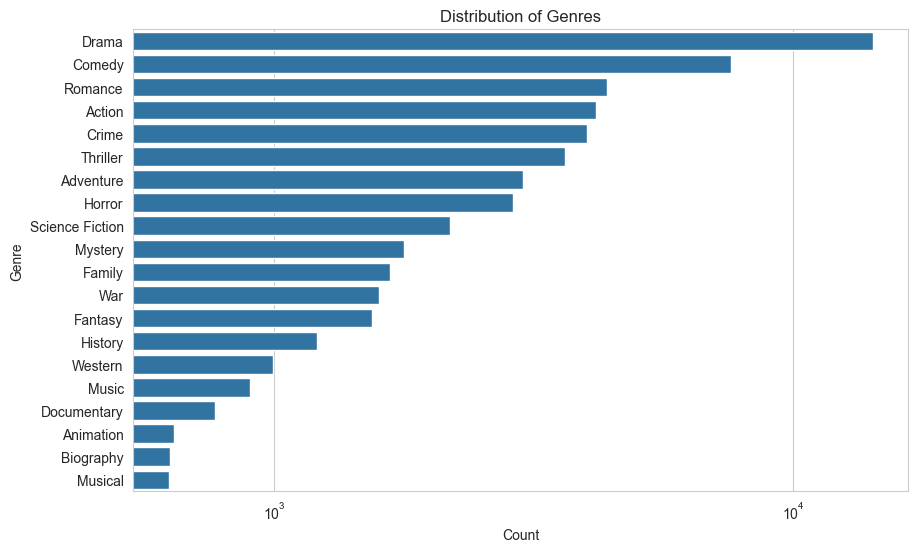

In [119]:
genres_df = movies_df[["countries", "cold_war_side", "genres", "release_date"]]
genres_df = genres_df.explode("genres")[genres_df.explode("genres") != "\\N"]
genres_df["genres"] = (
    genres_df["genres"].str.title().str.strip().replace({"Sci-Fi": "Science Fiction"})
)

genre_counts = genres_df["genres"].value_counts().head(20)
common_genres = genre_counts.head(12).index

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title("Distribution of Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.xscale("log")
plt.show()

Then Plot the distribution of genres for the movies we are studying (those either in the "Eastern" cold_war_side or the "Western" cold_war_side)

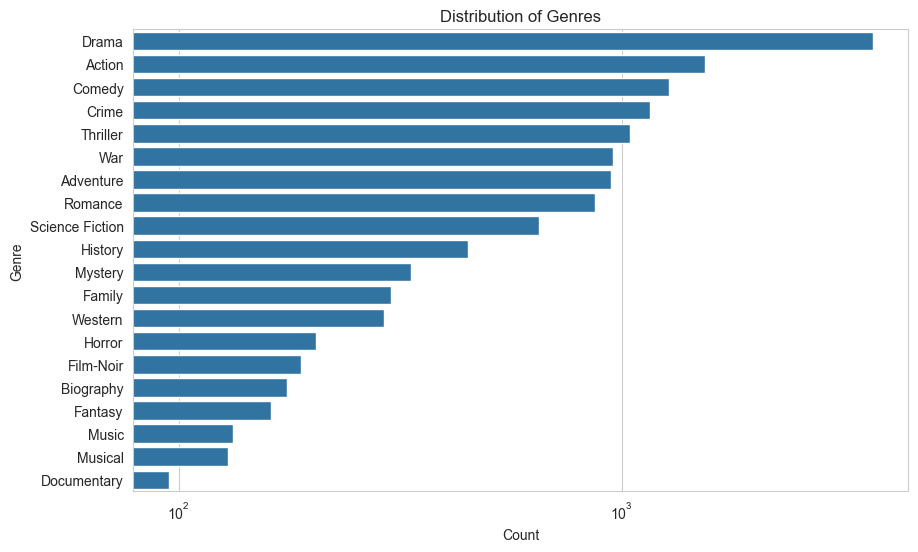

Index(['Drama', 'Action', 'Comedy', 'Crime', 'Thriller', 'War', 'Adventure',
       'Romance', 'Science Fiction', 'History'],
      dtype='object', name='genres')

In [120]:
genres_df = genres_df[genres_df["cold_war_side"].isin(["Eastern", "Western"])]

genre_counts = genres_df["genres"].value_counts().head(20)
common_genres = genre_counts.head(10).index

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title("Distribution of Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.xscale("log")
plt.show()
common_genres

Now plot the distribution of genres per side

In [121]:
def plot_distributions(
    western_counts,
    eastern_counts,
    title_western,
    title_eastern,
    xlabel="Genre",
    figsize=(20, 9),
    color_western="#1f77b4",
    color_eastern="#ff6347",
    log_scale=True,
):
    max_y = max(western_counts.head(20).max(), eastern_counts.head(20).max())
    min_y = min(western_counts.head(20).min(), eastern_counts.head(20).min())
    fig, axes = plt.subplots(1, 2, figsize=figsize)  # 1 row, 2 columns
    sns.set_style(style="whitegrid")

    # Western plot
    sns.barplot(
        x=western_counts.head(15).index,
        y=western_counts.head(15).values,
        color=color_western,
        ax=axes[0],
    )
    axes[0].set_title(title_western)
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis="x", rotation=45)

    if log_scale:
        axes[0].set_yscale("log")
    axes[0].set_ylim(min_y, max_y + 100)

    # Eastern plot
    sns.barplot(
        x=eastern_counts.head(15).index,
        y=eastern_counts.head(15).values,
        color=color_eastern,
        ax=axes[1],
    )
    axes[1].set_title(title_eastern)
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis="x", rotation=45)

    if log_scale:
        axes[1].set_yscale("log")
    axes[1].set_ylim(min_y, max_y + 100)

    plt.tight_layout()
    plt.show()

Without Log x scale

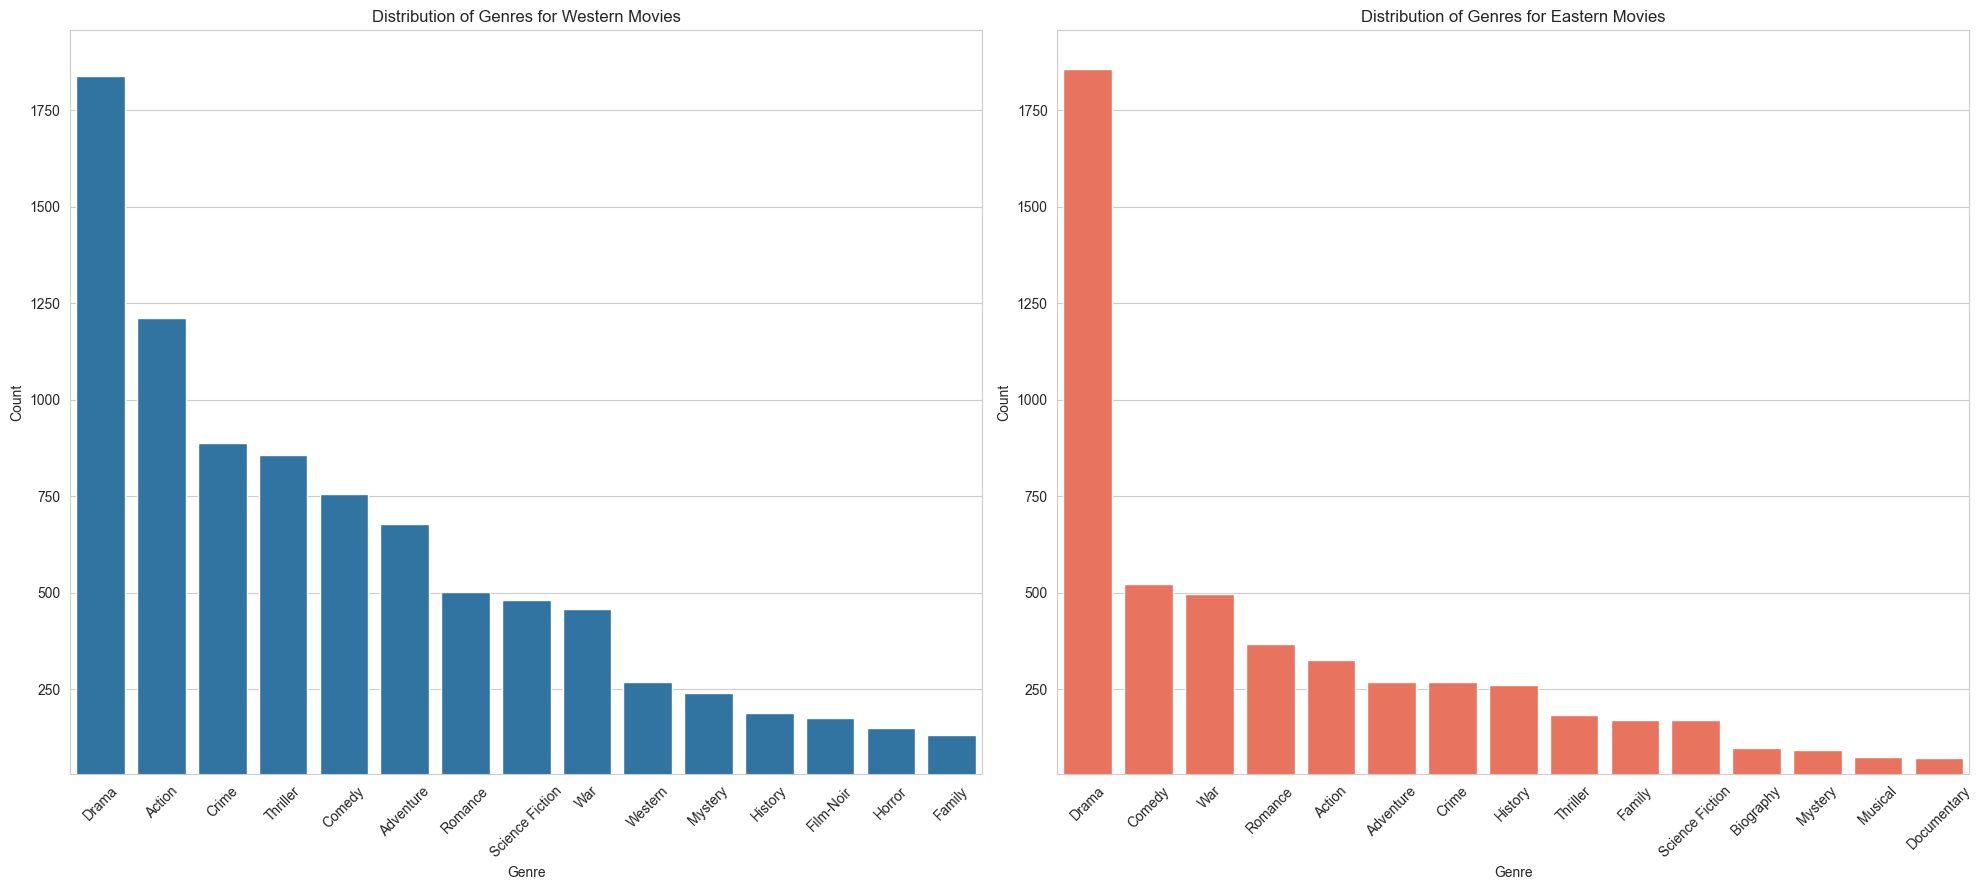

In [122]:
western_genre_counts = genres_df[genres_df["cold_war_side"] == "Western"][
    "genres"
].value_counts()
eastern_genre_counts = genres_df[genres_df["cold_war_side"] == "Eastern"][
    "genres"
].value_counts()

plot_distributions(
    western_genre_counts,
    eastern_genre_counts,
    title_western="Distribution of Genres for Western Movies",
    title_eastern="Distribution of Genres for Eastern Movies",
    xlabel="Genre",
    log_scale=False,
)

With log x scale

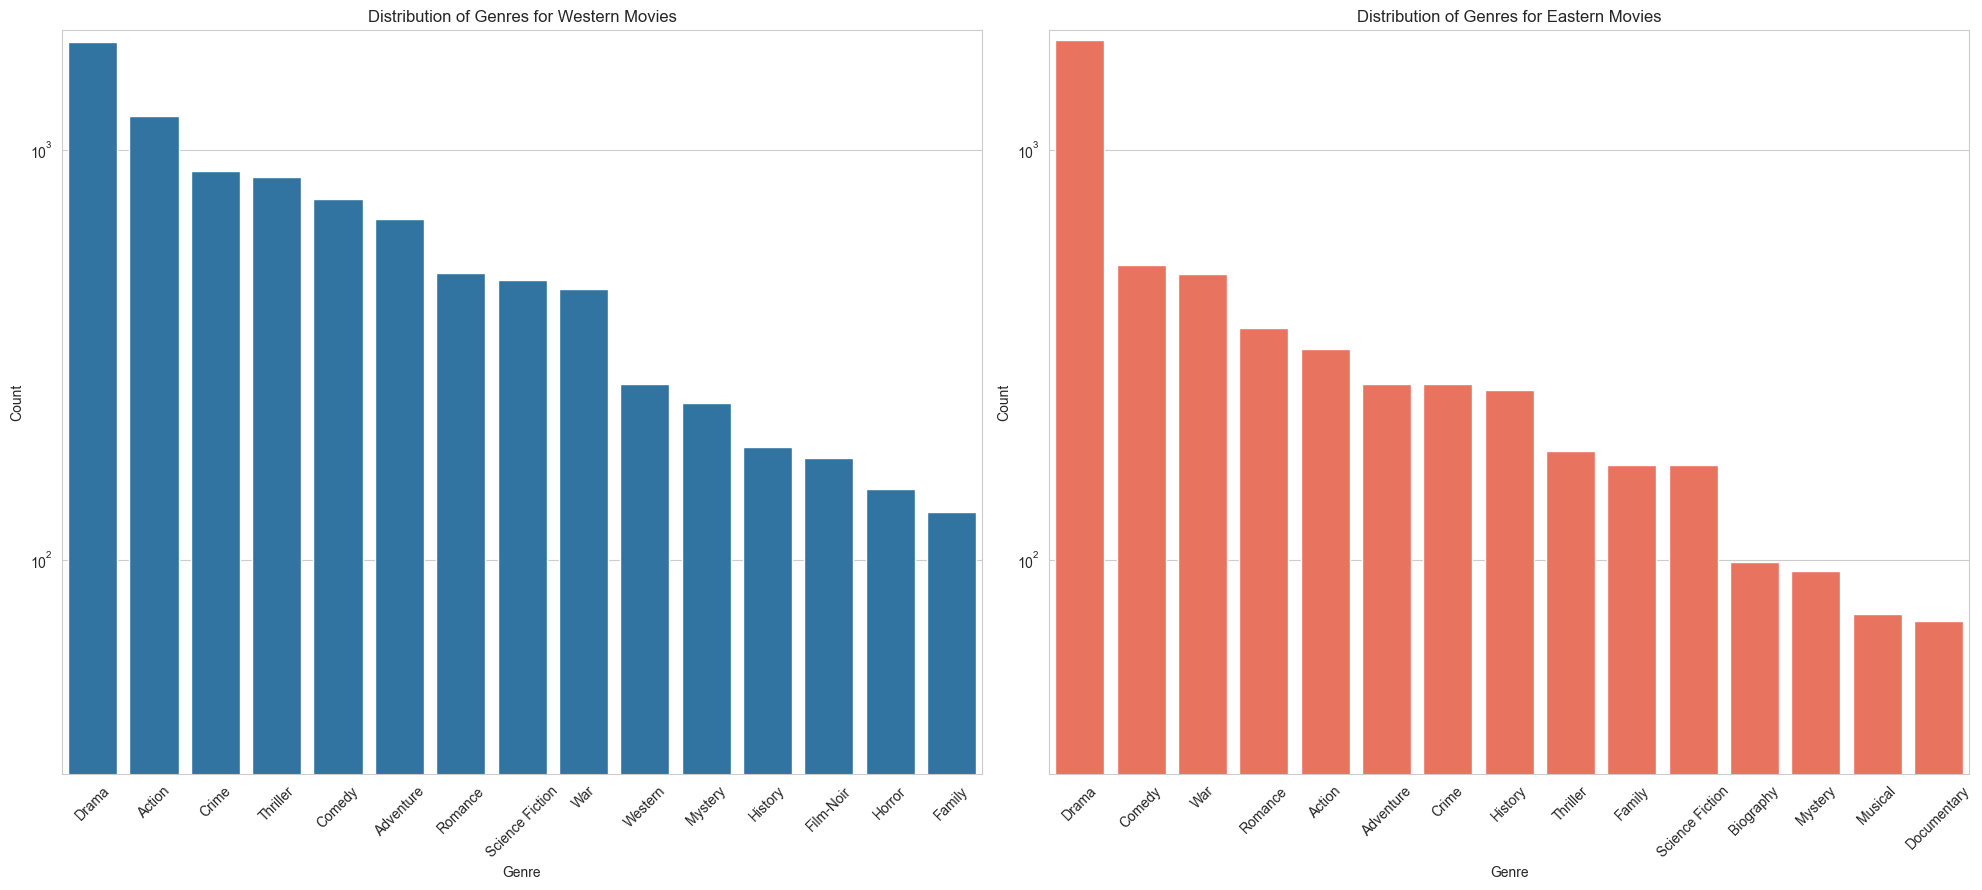

In [123]:
plot_distributions(
    western_genre_counts,
    eastern_genre_counts,
    title_western="Distribution of Genres for Western Movies",
    title_eastern="Distribution of Genres for Eastern Movies",
    xlabel="Genre",
    log_scale=True,
)

Most of the genres appear in the same frequency in both sides. We can instead look at the relative difference between genre count in the eastern side and the western side.

$\textit{relative\_difference} = \frac{\textit{Eastern\_count} - \textit{Western\_count}}{\textit{Eastern\_count} + \textit{Western\_count}}$

In [124]:
def create_comparison_df(
    west_df,
    east_df,
    threshold,
    common_genres=[
        "Drama",
        "Action",
        "Comedy",
        "Crime",
        "Thriller",
        "War",
        "Adventure",
        "Romance",
        "History",
        "Science Fiction",
    ],
):
    comparison_df = pd.DataFrame({"Western": west_df, "Eastern": east_df}).fillna(0)

    comparison_df["relative_difference"] = (
        comparison_df["Eastern"] - comparison_df["Western"]
    ) / (comparison_df["Eastern"] + comparison_df["Western"])

    comparison_df["absolute_relative_difference"] = comparison_df[
        "relative_difference"
    ].abs()

    comparison_df["Eastern_Proportion"] = (
        comparison_df["Eastern"] / comparison_df["Eastern"].sum(axis=0) * 100
    )
    comparison_df["Western_Proportion"] = (
        comparison_df["Western"] / comparison_df["Western"].sum(axis=0) * 100
    )

    comparison_df["proportion_relative_difference"] = (
        comparison_df["Eastern_Proportion"] - comparison_df["Western_Proportion"]
    ) / (comparison_df["Eastern_Proportion"] + comparison_df["Western_Proportion"])
    comparison_df["absolute_proportion_relative_difference"] = comparison_df[
        "proportion_relative_difference"
    ].abs()

    comparison_df["total"] = comparison_df["Eastern"] + comparison_df["Western"]

    comparison_df = (
        comparison_df[
            (comparison_df["Eastern"] > threshold)
            | (comparison_df["Western"] > threshold)
        ]
        .sort_values("absolute_relative_difference", ascending=False)
        .head(20)
    )
    return comparison_df

In [125]:
genre_comparison = create_comparison_df(western_genre_counts, eastern_genre_counts, 20)
genre_comparison.head(5)

,Western,Eastern,relative_difference,absolute_relative_difference,Eastern_Proportion,Western_Proportion,proportion_relative_difference,absolute_proportion_relative_difference,total
genres,,,,,,,,,
Film-Noir,177,12.0,-0.873016,0.873016,0.217391,1.903021,-0.794954,0.794954,189.0
Western,269,22.0,-0.848797,0.848797,0.398551,2.892162,-0.757772,0.757772,291.0
Tv Movie,25,3.0,-0.785714,0.785714,0.054348,0.268788,-0.663623,0.663623,28.0
Thriller,858,184.0,-0.646833,0.646833,3.333333,9.224815,-0.469136,0.469136,1042.0
Action,1212,327.0,-0.575049,0.575049,5.923913,13.030857,-0.374942,0.374942,1539.0


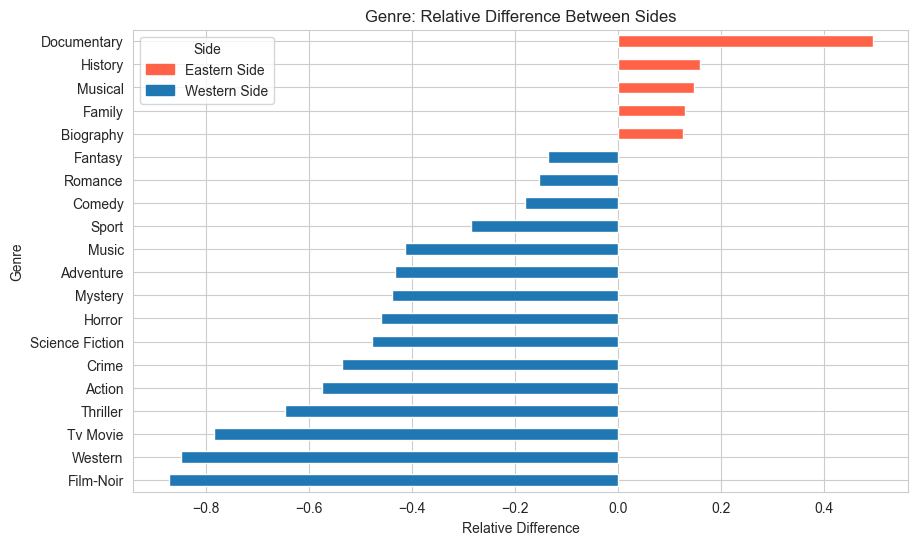

In [126]:
def plot_relative_difference(comparison_df, compared, abs=False, prop=False):
    column = "relative_difference"
    sort_column = "relative_difference"

    if prop:
        sort_column = "proportion_" + column
        column = "proportion_" + column
    if abs:
        column = "absolute_" + column

    comparison_df = comparison_df.sort_values(sort_column)
    comparison_df[column].plot(
        kind="barh",
        figsize=(10, 6),
        color=["#ff6347" if x > 0 else "#1f77b4" for x in comparison_df[sort_column]],
    )
    column = column.replace("_", " ").title()
    plt.title(f"{compared}: {column} Between Sides")
    plt.xlabel(f"{column}")
    plt.ylabel(f"{compared}")

    # Create custom legend
    legend_elements = [
        Patch(color="#ff6347", label="Eastern Side"),
        Patch(color="#1f77b4", label="Western Side"),
    ]
    plt.legend(handles=legend_elements, title="Side")
    plt.show()


plot_relative_difference(genre_comparison, "Genre", abs=False, prop=False)

We can look at the relative difference in proportion instead

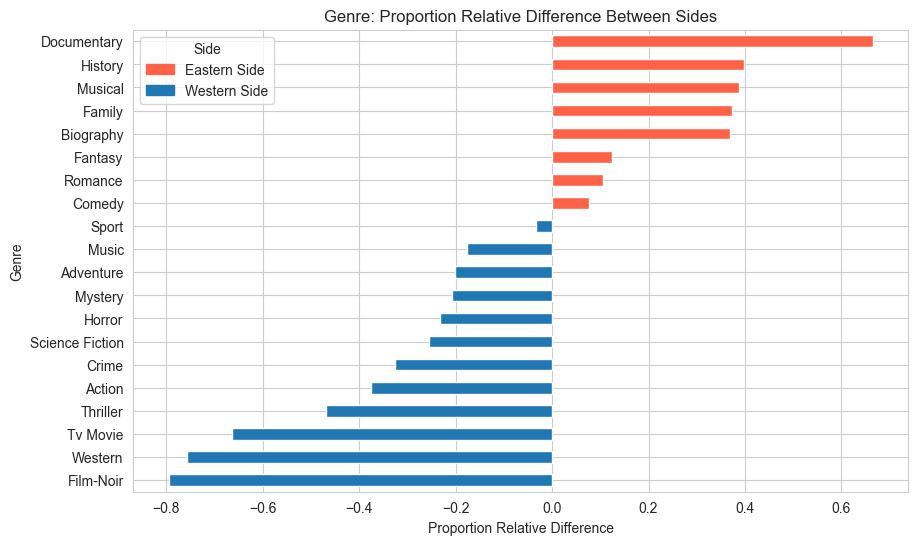

In [127]:
plot_relative_difference(genre_comparison, "Genre", abs=False, prop=True)

Documentaries and Historical movies appear far more in the eastern bloc, while Thrillers, Actions are more prevalent in the western bloc.
It is not surprising that westerns and film-noirs are a lot more common in the western side.

## Time Series


We can look now how the genre frequency changed over time.

First plot the count every year
Then plot the count each period (either every 5 years or through cold war periods)

In [128]:
western_genres_yearly_counts = (
    genres_df[genres_df["cold_war_side"] == "Western"]
    .explode("genres")
    .groupby("release_date")["genres"]
    .value_counts()
).reset_index()
eastern_genres_yearly_counts = (
    genres_df[genres_df["cold_war_side"] == "Eastern"]
    .explode("genres")
    .groupby("release_date")["genres"]
    .value_counts()
).reset_index()

eastern_genres_yearly_counts = eastern_genres_yearly_counts[
    eastern_genres_yearly_counts["genres"].isin(common_genres)
]
western_genres_yearly_counts = western_genres_yearly_counts[
    western_genres_yearly_counts["genres"].isin(common_genres)
]

In [129]:
def plot_genres_over_time(side_genres_counts, side):
    # Create the interactive line plot
    fig = px.line(
        side_genres_counts.reset_index(),
        x="release_date",
        y="count",
        color="genres",
        title=f"Genre Counts Over Time for {side} Movies",
        labels={"release_date": "Release Date", "Count": "Count", "Genre": "Genres"},
        template="plotly_white",
    )

    # Make all traces except War invisible by default
    fig.for_each_trace(
        lambda trace: (
            trace.update(visible="legendonly") if trace.name != "War" else None
        )
    )
    if side == "Eastern":
        fig.for_each_trace(lambda trace: trace.update(line_color="#ff6347"))
    elif side == "Western":
        fig.for_each_trace(lambda trace: trace.update(line_color="#1f77b4"))
    fig.show()

In [130]:
# Interactive widget
def interactive_plot(side_genres):
    if side_genres == "Western":
        plot_genres_over_time(western_genres_yearly_counts, "Western")
    elif side_genres == "Eastern":
        plot_genres_over_time(eastern_genres_yearly_counts, "Eastern")


# Use interact with a dropdown
interact(
    interactive_plot,
    side_genres=Dropdown(
        options=["Western", "Eastern"], value="Western", description="Region"
    ),
)

interactive(children=(Dropdown(description='Region', options=('Western', 'Eastern'), value='Western'), Output(…

<function __main__.interactive_plot(side_genres)>

In [131]:
def plot_genres_over_period(side_genres_counts, side):
    # Create the interactive line plot
    fig = px.bar(
        side_genres_counts.reset_index(),
        x="period",
        y="count",
        color="genres",
        title=f"Genre Counts Over Different Periods for {side} Movies",
        labels={"period": "Release Date", "Count": "Count", "Genre": "Genres"},
        template="plotly_white",
    )

    # Make all traces except War invisible by default
    fig.for_each_trace(
        lambda trace: (
            trace.update(visible="legendonly") if trace.name != "War" else None
        )
    )
    fig.for_each_trace(
        lambda trace: trace.update(
            marker_color="#ff6347" if side == "Eastern" else "#1f77b4"
        )
    )
    fig.show()

Either change the Side by interaction


In [132]:
bins = [1945, 1953, 1962, 1974, 1984, 1995]
labels = [
    "Blocs Establishment",
    "Major tensions and crises",
    "Détente",
    "Second Cold War",
    "End of the Cold War",
]

# bins = list(range(1945, 1996, 5))
# labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]

genres_df["period"] = pd.cut(genres_df["release_date"], bins, labels=labels, right=True)

period_counts = (
    genres_df.explode("genres")
    .groupby(["period", "cold_war_side"], observed=False)["genres"]
    .value_counts()
    .reset_index()
)
period_counts = period_counts[period_counts["genres"].isin(common_genres)]
eastern_period_counts = period_counts[
    period_counts["cold_war_side"] == "Eastern"
].reset_index()
western_period_counts = period_counts[
    period_counts["cold_war_side"] == "Western"
].reset_index()


# Interactive widget
def interactive_plot(side_genres):
    if side_genres == "Western":
        plot_genres_over_period(western_period_counts, "Western")
    elif side_genres == "Eastern":
        plot_genres_over_period(eastern_period_counts, "Eastern")


# Use interact with a dropdown
interact(
    interactive_plot,
    side_genres=Dropdown(
        options=["Western", "Eastern"], value="Western", description="Region"
    ),
)

interactive(children=(Dropdown(description='Region', options=('Western', 'Eastern'), value='Western'), Output(…

<function __main__.interactive_plot(side_genres)>

Or make Genres interactive

In [133]:
# Create Plotly figure function
def plot_genre_over_periods(df, genre):
    fig = px.bar(
        df[df["genres"] == genre],
        x="period",
        y="count",
        color="cold_war_side",
        title=f"{genre} Movie Counts Over Different Periods",
        labels={
            "period": "Period",
            "count": "Count",
            "genres": "Genres",
            "cold_war_side": "Side",
        },
        template="plotly_white",
        barmode="group",
        color_discrete_map={
            "Western": "#1f77b4",  # Assign "Western" to blue
            "Eastern": "#ff6347",  # Assign "Eastern" to red
        },
    )

    fig.update_layout(
        hovermode="x unified",
        title=dict(x=0.5, xanchor="center"),
    )
    return fig


interact(
    lambda genre: plot_genre_over_periods(
        period_counts[period_counts["cold_war_side"].isin(["Western", "Eastern"])],
        genre,
    ),
    genre=Dropdown(options=common_genres, value="War", description="Genre"),
)

interactive(children=(Dropdown(description='Genre', index=5, options=('Drama', 'Action', 'Comedy', 'Crime', 'T…

<function __main__.<lambda>(genre)>

In [134]:
movies_df.dropna(subset=["genres", "release_date"])[
    (
        movies_df.dropna(subset=["genres", "release_date"])["genres"].apply(
            lambda x: "War" in x
        )
    )
    & (movies_df.dropna(subset=["genres", "release_date"])["release_date"] < 1974)
    & (movies_df.dropna(subset=["genres", "release_date"])["release_date"] > 1963)
    & (movies_df["cold_war_side"] == "Eastern")
]

C:\Users\karim\AppData\Local\Temp\ipykernel_15860\2905481464.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,title,languages,countries,genres,release_date,cold_war_side,character_western_bloc_representation,character_eastern_bloc_representation,western_bloc_values,eastern_bloc_values,theme
72,17th Parallel: Vietnam in War,NaN,[Russia],"[War, Documentary]",1968,Eastern,[None],"[Ivens, North Vietnamese colleagues, anti-war ...",[None],"[anti-war sentiment, advocacy for peace, human...","[themes of war, documentary filmmaking, peace,..."
143,5th Day of Peace,"[Italian, English, German]","[Croatia, Italy]","[Drama, War]",1970,Eastern,[None],"[Ens. Bruno Grauber, Cpl. Reiner Schultz, Germ...","[Canadian General Snow, Captain Miller, author...","[Military discipline, cowardice, moral conflic...","[War, betrayal, justice, desertion, ethical di..."
380,A Hard Little Nut,NaN,[Russia],"[Comedy, Romance, War]",1968,Eastern,"[Soviet soldiers, bravery, sacrifice, hero arc...",[None],"[Bravery, sacrifice, camaraderie, resilience]",[None],"[War, survival, heroism, Soviet soldiers, Worl..."
745,A Woman's Kingdom,NaN,[Russia],"[Drama, War]",1968,Eastern,[None],"[Soviet woman, resilience, righteousness, trag...","[Hardworking, perseverance, sacrifice, survival]",[None],"[World War II, resistance, personal struggle, ..."
885,Adelheid,"[Czech, German]",[Czech Republic],"[Romance, Drama, War]",1969,Eastern,[None],"[Czech soldier, patriotic values, conflicted a...",[None],"[Love, loyalty, conflict, moral dilemma]","[Post-WWII, love, reconciliation, conscience]"
...,...,...,...,...,...,...,...,...,...,...,...
25375,Za nami Moskva,NaN,[Russia],[War],1968,Eastern,[None],"[Panfilov division, heroism, sacrifice, archet...",[None],"[heroism, sacrifice, unity, patriotism]","[war, heroism, sacrifice, WWII, Soviet valor]"
25465,"Zemlya, do vostrebovaniya",NaN,[Russia],"[Drama, War]",1973,Eastern,[None],"[Lev Manevich, loyalty to Soviet Union, hero]","[Soviet Union, espionage, sacrifice for the st...","[Nazi Germany, threats, danger to the protagon...","[Espionage, loyalty, sacrifice, danger, intell..."
25479,Zhavoronok,NaN,[Russia],"[War, Drama, History]",1965,Eastern,[None],"[Soviet POWs, bravery, camaraderie, heroism]",[None],"[bravery, sacrifice, collective strength]","[World War II, courage, survival, resistance]"
25514,Zimnee utro,NaN,[Russia],"[Drama, War]",1967,Eastern,[None],"[Katherine, Seryozha's father, care, resilienc...",[None],"[Compassion, survival, community support, resi...","[Sacrifice, hope, childhood innocence, war imp..."


We see that war movies begin decreasing in frequency starting from the detente period 

# Theme Analysis

We do similar analysis for themes

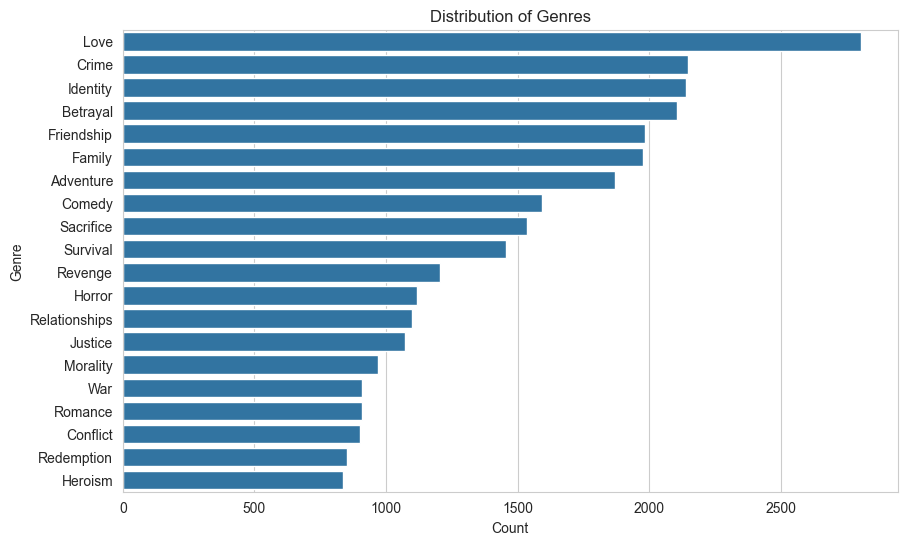

In [135]:
themes_df = (
    movies_df[["genres", "cold_war_side", "theme", "release_date"]]
    .explode("theme")
    .reset_index()
)
themes_df["theme"] = (
    themes_df["theme"]
    .str.title()
    .str.strip()
    .replace({"Wwii": "World War II", "World War Ii": "World War II"})
)
themes_df = themes_df[themes_df["theme"] != "None"].dropna(subset="genres")

theme_counts = themes_df["theme"].value_counts().head(20)
# Plot the distribution
plt.figure(figsize=(10, 6))

sns.barplot(
    x=theme_counts.values,
    y=theme_counts.index,
)

plt.title("Distribution of Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

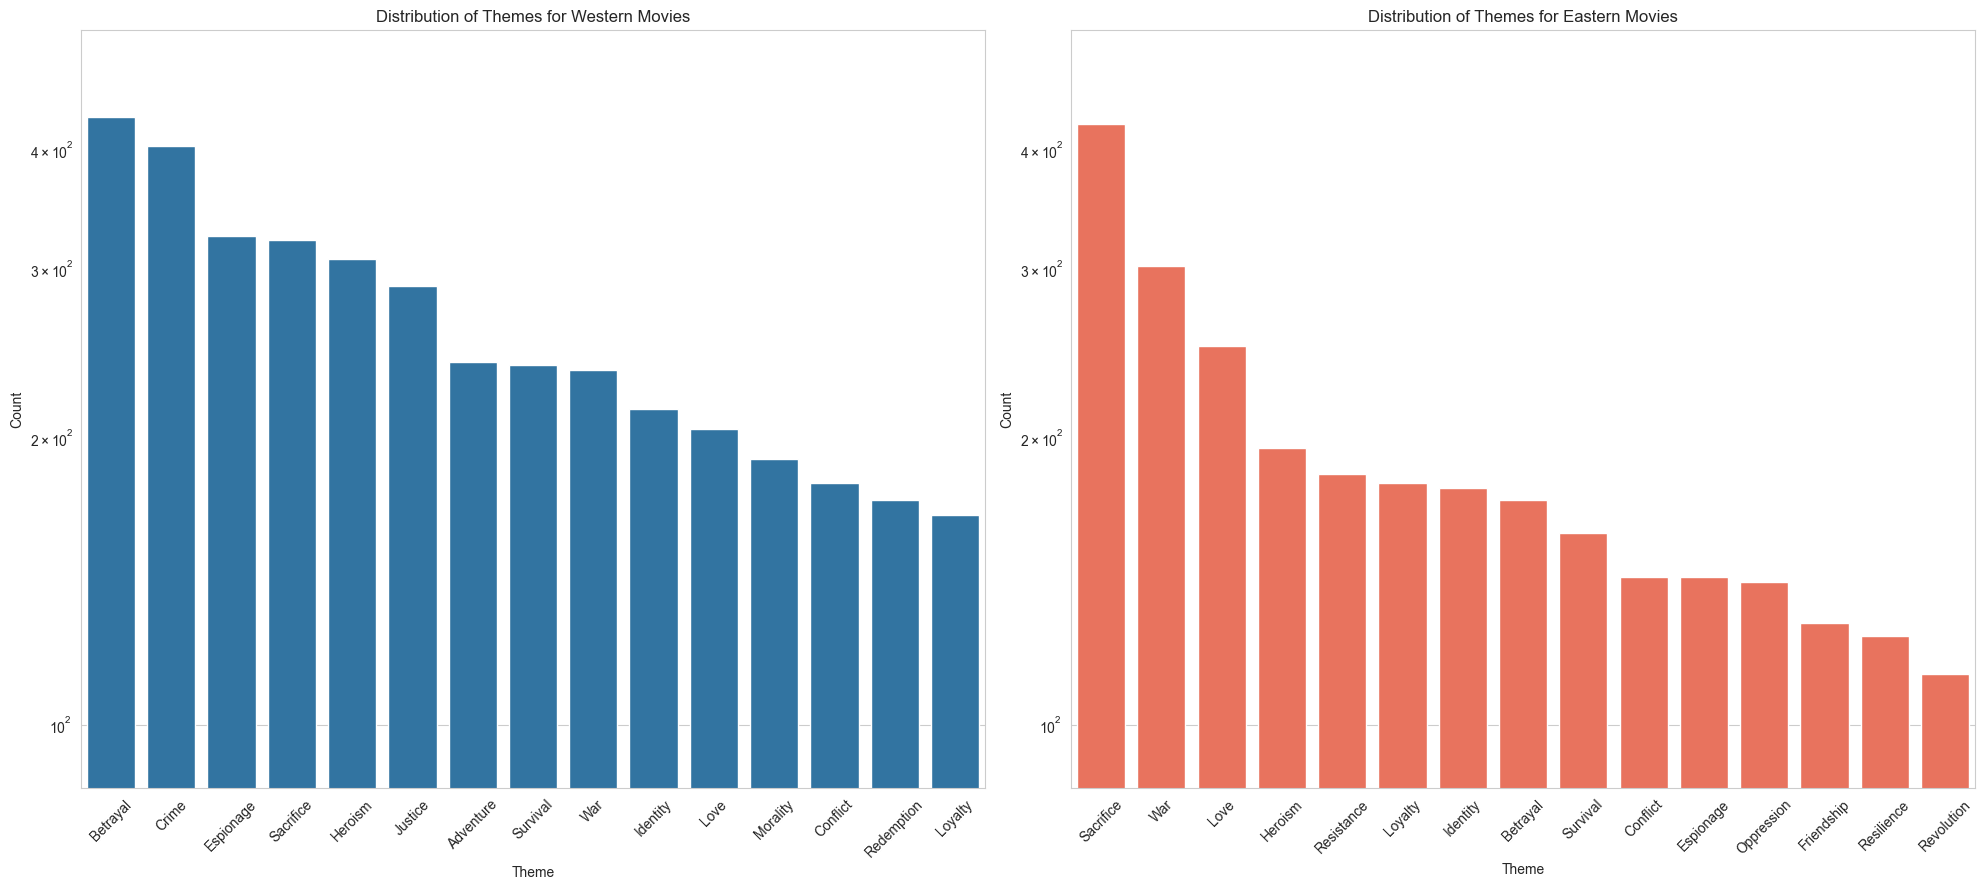

In [136]:
western_theme_counts = (
    themes_df[themes_df["cold_war_side"] == "Western"]["theme"]
    .explode("theme")
    .value_counts()
)
eastern_theme_counts = (
    themes_df[themes_df["cold_war_side"] == "Eastern"]["theme"]
    .explode("theme")
    .value_counts()
)

plot_distributions(
    western_theme_counts,
    eastern_theme_counts,
    title_western="Distribution of Themes for Western Movies",
    title_eastern="Distribution of Themes for Eastern Movies",
    xlabel="Theme",
)

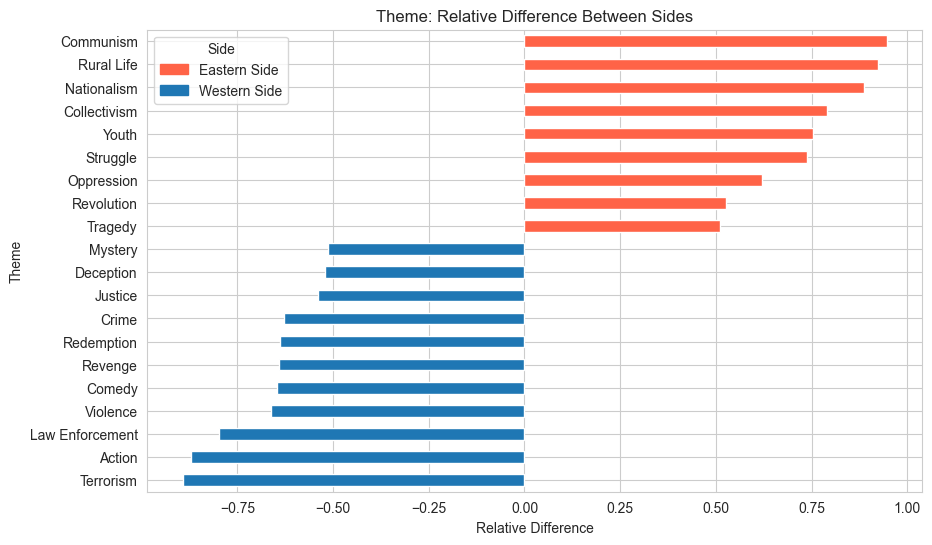

In [137]:
theme_comparison = create_comparison_df(western_theme_counts, eastern_theme_counts, 50)
plot_relative_difference(theme_comparison, "Theme")

We can look at themes present in War Movies Specifically

In [138]:
eastern_war_themes = themes_df[
    (themes_df["cold_war_side"] == "Eastern")
    & (themes_df["genres"].apply(lambda x: "War" in x))
]
western_war_themes = themes_df[
    (themes_df["cold_war_side"] == "Western")
    & (themes_df["genres"].apply(lambda x: "War" in x))
]
western_war_themes_counts = western_war_themes["theme"].value_counts()
eastern_war_themes_counts = eastern_war_themes["theme"].value_counts()

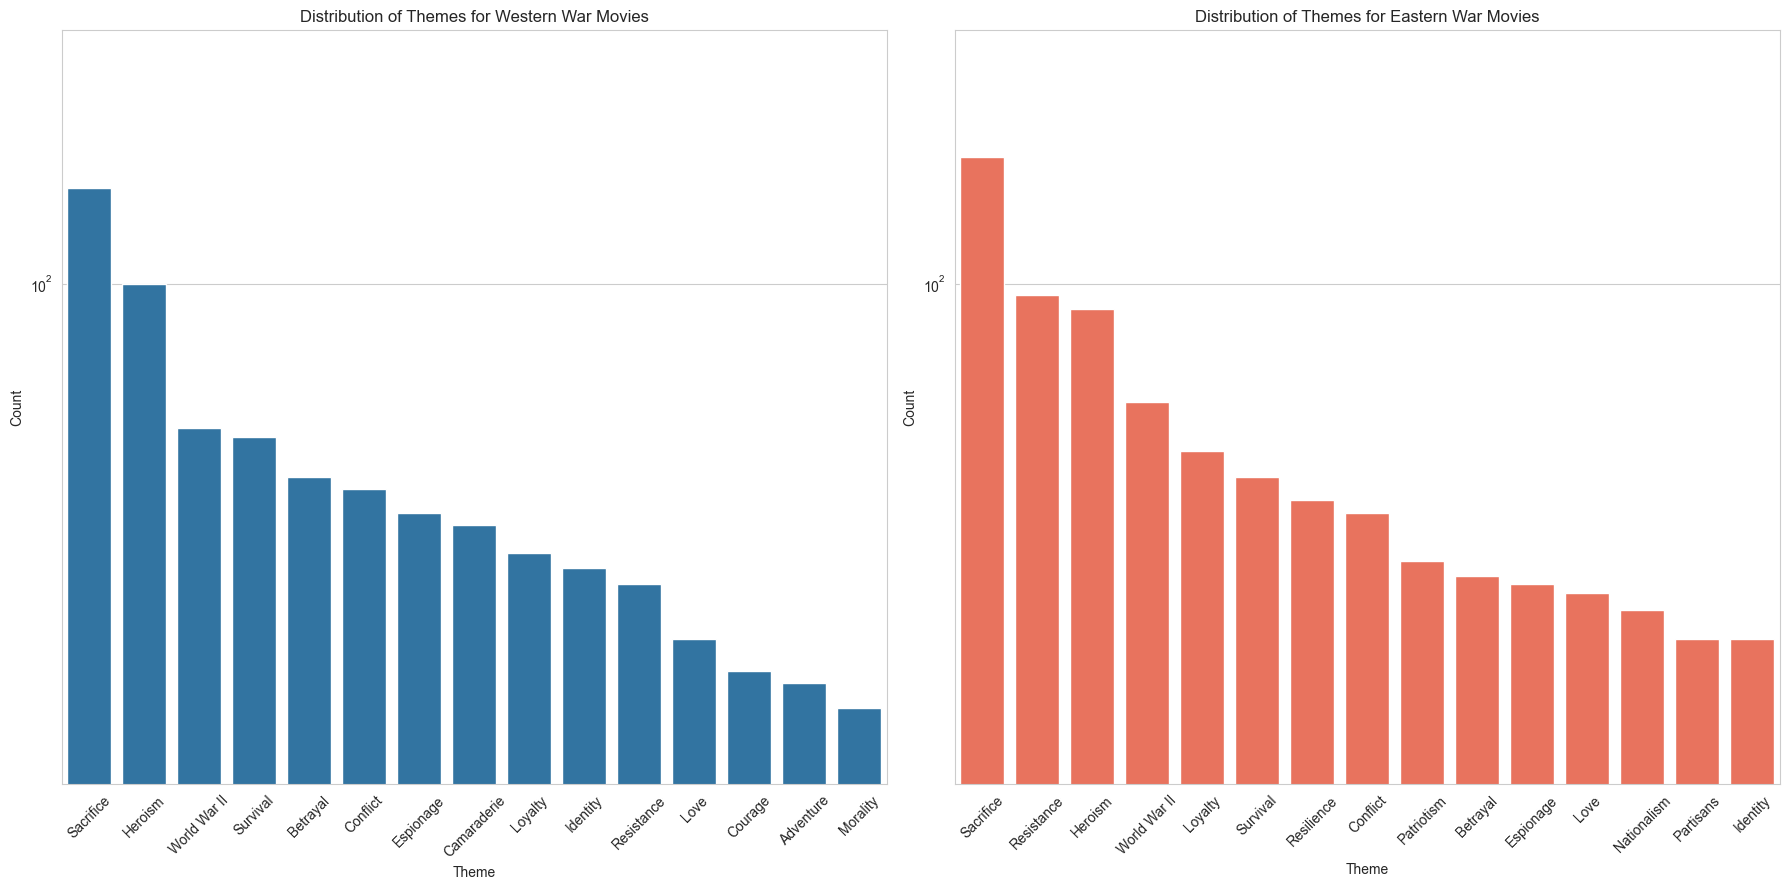

In [139]:
# remove war from themes
western_war_themes_counts = western_war_themes_counts[
    western_war_themes_counts.index != "War"
]
eastern_war_themes_counts = eastern_war_themes_counts[
    eastern_war_themes_counts.index != "War"
]

plot_distributions(
    western_war_themes_counts,
    eastern_war_themes_counts,
    title_western="Distribution of Themes for Western War Movies",
    title_eastern="Distribution of Themes for Eastern War Movies",
    xlabel="Theme",
    figsize=(18, 9),
    log_scale=True,
)

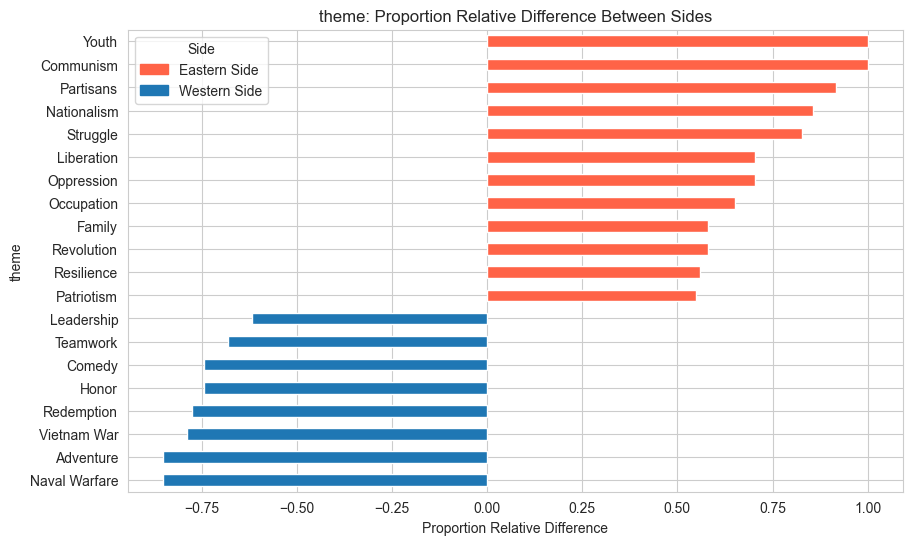

In [146]:
war_theme_comparison = create_comparison_df(
    western_war_themes_counts, eastern_war_themes_counts, 10
)


plot_relative_difference(war_theme_comparison, "theme", prop=True)

In [141]:
movies_df.dropna(subset=["genres", "theme", "cold_war_side"])[
    (
        movies_df.dropna(subset=["genres", "theme", "cold_war_side"])["genres"].apply(
            lambda x: "War" in x
        )
    )
    & (
        movies_df.dropna(subset=["genres", "theme", "cold_war_side"])["cold_war_side"]
        == "Western"
    )
    & (
        movies_df.dropna(subset=["genres", "theme", "cold_war_side"])["theme"].apply(
            lambda x: "Comedy" in x
        )
    )
]

## first Film is British, second film is american (check on google)

,title,languages,countries,genres,release_date,cold_war_side,character_western_bloc_representation,character_eastern_bloc_representation,western_bloc_values,eastern_bloc_values,theme
5337,Don't Panic Chaps,NaN,[Russia],"[Comedy, War]",1959,Western,[ The Good Soldier],[ The Antagonist],"[Camaraderie, humor, diplomacy, peaceful coexi...","[Militarism, discipline, national pride]","[Comedy, military, peace, cultural clash ]"
12923,No Time for Sergeants,NaN,[Russia],"[Comedy, War]",1958,Western,"[Will Stockdale, values of humor, resilience, ...","[M/Sgt. King, values of mentorship and duty, a...",[None],[None],"[Comedy, military life, underdog, humor, resil..."
14430,Privates on Parade,[English],[United Kingdom],"[Comedy, Drama, War]",1983,Western,"[Major Giles Flack, Traditional British values...",[None],"[British army personnel, Comedic camaraderie, ...",[None],"[War, Comedy, Colonialism, Military entertainm..."
22666,The Wackiest Ship in the Army,[English],[United States of America],"[Comedy, Family, Drama, War]",1960,Western,"[Lieutenant Rip Crandall, determined, honorabl...",[None],"[Camaraderie, adventure, humor, teamwork]",[None],"[Comedy, military, misfits, adventure, teamwor..."
24690,"What Did You Do in the War, Daddy?","[Italian, English, German]",[United States of America],"[Comedy, War]",1966,Western,"[Lt. Christian, values friendship and camarade...","[Capitano Fausto Oppo, values tradition and co...","[American soldiers, teamwork, humor, courage, ...","[Italian officers, hospitality, the value of f...","[Comedy, war, absurdity, cultural exchange, hu..."
24807,Which Way to the Front?,[English],[United States of America],"[Comedy, War]",1970,Western,"[Brendan Byers III, rich, patriotic, resourcef...",[None],"[Patriotism, resourcefulness, individualism, H...",[None],"[Comedy, War, Heroism, patriotism, improvisation]"
